In [1]:
import pandas as pd
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from torch import nn, optim
import time
from tempfile import TemporaryDirectory
import os

device = torch.device('cuda:0')

In [2]:
rows = pd.read_csv('content/outFrames/content.csv')

In [3]:
frames = { 'Train': [], 'Test': [] }
class_idxs =  { 'UD': 0, 'WF': 1, 'None': 2 } 
class_names = [ 'UD', 'WF', 'None' ]
main_ndarray = np.load('content/frame_array.npy')
main_ndarray = main_ndarray.astype('float32')

# BGR->RGB
main_ndarray = np.stack([
    main_ndarray[:, :, :, 2],
    main_ndarray[:, :, :, 1],
    main_ndarray[:, :, :, 0],
], axis=-1)
# (H,W,C) -> (C,W,H)
main_ndarray = main_ndarray.transpose((0, 3, 1, 2))
# Normalize
main_ndarray = (main_ndarray - 128.0) / 128.0 

grouped = rows.groupby(['video_name', 'interval', 'class', 'type'], as_index=False)
count = 0
for grp, values in grouped:
    if len(values) < 16:
        continue

    # TODO: Can get more sample if values is larger than 16 frame
    idxs = []
    for idx, row in values.iterrows():
        idxs.append(idx)
        if len(idxs) == 16:
            frame_ndarray = main_ndarray[idxs,]
            frames[grp[3]].append((frame_ndarray, class_idxs[grp[2]]))
            idxs = []

In [36]:
dataloaders = {
    'Train': torch.utils.data.DataLoader(frames['Train'], batch_size=4, shuffle=True, num_workers=4),
    'Test': torch.utils.data.DataLoader(frames['Test'], batch_size=4, shuffle=True, num_workers=4),
}

dataset_sizes = {
    'Train': len(frames['Train']),
    'Test': len(frames['Test']), 
}

print(f'Size of training set {dataset_sizes["Train"]}')
print(f'Size of testing set {dataset_sizes["Test"]}')

Size of training set 126
Size of testing set 41


In [5]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


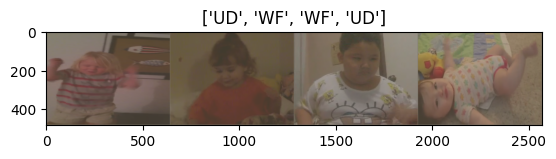

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

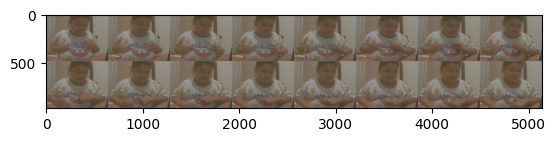

In [7]:
# Get a frame
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[0,:]

# Make a grid from frame
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [42]:
def train_model(model, criterion, optimizer, scheduler, transform=None, num_epochs=25):
    since = time.time()
    losses = {'Train': [], 'Test': []}
    accuracies = {'Train': [], 'Test': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = './best_model_params.pt'

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['Train', 'Test']:
                if phase == 'Train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    if transform != None:
                        inputs = transform(inputs).to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                losses[phase].append(float(epoch_loss))
                accuracies[phase].append(float(epoch_acc))

                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            # Stop early on two consecutive higher test loss
            if len(losses['Test']) > 2 and losses['Test'][-1] > losses['Test'][-2] and losses['Test'][-2] > losses['Test'][-3]:
                break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    _, axes = plt.subplots(2, 1)
    axes[0].plot(losses['Train'], label='Train loss')
    axes[0].plot(losses['Test'], label='Test loss')
    axes[0].legend()
    
    axes[1].plot(accuracies['Train'], label='Train accuracy')
    axes[1].plot(accuracies['Test'], label='Test accuracy')
    axes[1].legend()
    
    return model

In [41]:
model_ft = torchvision.models.video.mvit_v2_s(weights=torchvision.models.video.MViT_V2_S_Weights.KINETICS400_V1)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(768, len(class_names)),
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
Train Loss: 0.8588 Acc: 0.7143
Test Loss: 0.6837 Acc: 0.9024
Epoch 1/24
----------
Train Loss: 0.4123 Acc: 0.9603
Test Loss: 0.4547 Acc: 0.9024
Epoch 2/24
----------
Train Loss: 0.2227 Acc: 0.9603
Test Loss: 0.3604 Acc: 0.9024
Epoch 3/24
----------
Train Loss: 0.1340 Acc: 0.9921
Test Loss: 0.3019 Acc: 0.8780
Epoch 4/24
----------
Train Loss: 0.1016 Acc: 0.9921
Test Loss: 0.2693 Acc: 0.8780
Epoch 5/24
----------
Train Loss: 0.0632 Acc: 0.9921
Test Loss: 0.2911 Acc: 0.8780
Epoch 6/24
----------
Train Loss: 0.0478 Acc: 1.0000
Test Loss: 0.2710 Acc: 0.8780
Epoch 7/24
----------
Train Loss: 0.0407 Acc: 1.0000
Test Loss: 0.2734 Acc: 0.8780
Epoch 8/24
----------
Train Loss: 0.0440 Acc: 1.0000
Test Loss: 0.2770 Acc: 0.8780
Training complete in 1m 48s
Best val Acc: 0.902439


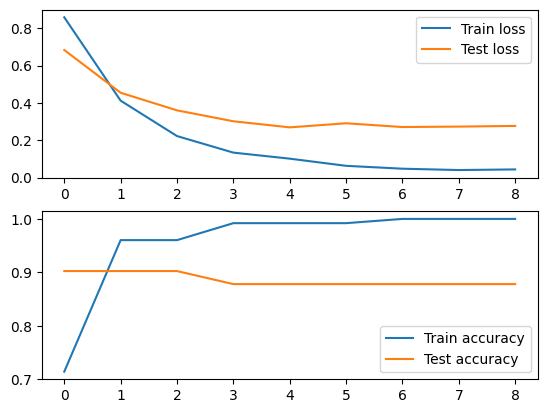

In [43]:
model_transform = torchvision.models.video.MViT_V2_S_Weights.KINETICS400_V1.transforms()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, transform=model_transform,
                       num_epochs=25)

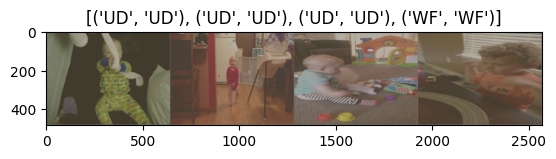

In [44]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Test']))

inferred_class = model_ft(model_transform(inputs.to(device)))

predicted_class = list(torch.argmax(inferred_class, dim=-1))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[(class_names[classes[x]], class_names[predicted_class[x]]) for x in range(len(classes))])